Epoch [1/200], Loss: 10794512.0000
Epoch [2/200], Loss: 10792513.0000
Epoch [3/200], Loss: 7960153.0000
Epoch [4/200], Loss: 6368393.5000
Epoch [5/200], Loss: 5600606.5000
Epoch [6/200], Loss: 4467859.5000
Epoch [7/200], Loss: 3241101.2500
Epoch [8/200], Loss: 1742679.7500
Epoch [9/200], Loss: 635049.0625
Epoch [10/200], Loss: 638106.0625
Epoch [11/200], Loss: 643659.1250
Epoch [12/200], Loss: 381386.1562
Epoch [13/200], Loss: 744729.0000
Epoch [14/200], Loss: 369608.1875
Epoch [15/200], Loss: 287674.8438
Epoch [16/200], Loss: 41148.8555
Epoch [17/200], Loss: 268189.9688
Epoch [18/200], Loss: 275387.9375
Epoch [19/200], Loss: 912286.3750
Epoch [20/200], Loss: 183733.0000
Epoch [21/200], Loss: 352943.9062
Epoch [22/200], Loss: 1652.5337
Epoch [23/200], Loss: 236346.0000
Epoch [24/200], Loss: 311409.5000
Epoch [25/200], Loss: 2962.3518
Epoch [26/200], Loss: 338556.9375
Epoch [27/200], Loss: 336708.7500
Epoch [28/200], Loss: 399066.4062
Epoch [29/200], Loss: 150972.8438
Epoch [30/200], Lo

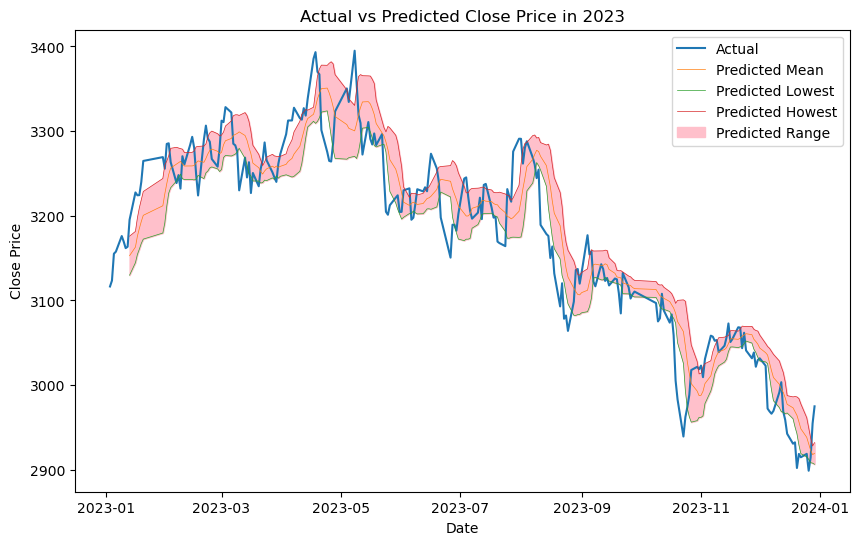

In [9]:
!pip install yfinance
import torch 
import yfinance as yf
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset,DataLoader
#pytorch实现CNN
#sklearn处理数据和划分数据集
#**********************************雅虎财经导入数据*********************************************
#选择的是上证综指
ticker = "000001.SS"
stock = yf.Ticker(ticker)
data = stock.history(period="1d", start="2018-01-01", end="2022-12-31")
#剔除非交易日数据、股利和拆股
data = data[data['Volume'] > 0]                            
data.drop(columns=['Dividends', 'Stock Splits'], inplace=True)
#**********************************数据归一化处理************************************************
#选择特征目标
features=[ 'Open','High','Low', 'Close','Volume']
target='Close'
#归一化特征
scaler=MinMaxScaler()
features_data=scaler.fit_transform(data[features])
#***********************************构造时间序列**************************************************
def create_sequences(input_data,target_data,time_steps):
    X,Y=[],[]
    for i in range(len(input_data)-time_steps):
        X.append(input_data[i:(i+time_steps)])
        Y.append(target_data[i+time_steps])
    return np.array(X),np.array(Y)
#这里的time_steps是调参得出的较优解
time_steps=8
X,Y=create_sequences(features_data,data[target].values,time_steps)
#***********************************划分数据集**************************************************
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=42)
#将数据转换为Tensors，便于torch训练
features_tensor =torch.Tensor(features_data)
targets_tensor=torch.Tensor(data[target].values)
#创建TensorDataset和DataLoader
dataset=TensorDataset(features_tensor,targets_tensor)
dataloader=DataLoader(dataset,batch_size=4,shuffle=True)
#这里batch是批处理，把数据集划分为组，batch_size是组的大小，batch_size小可以增加随机性避免过拟合
#shuffle是随机打乱，此处设置为true
#**********************************定义RNN模型************************************************
class SimpleNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
# 实例化模型，这里
model1 = SimpleNet(input_size=5, hidden_size=64, output_size=1)
# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)
# 训练
num_epochs = 200
for epoch in range(num_epochs):
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model1(inputs)
        targets = targets.unsqueeze(1)  # 调整目标值的形状以匹配模型输出
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    # 打印损失
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
#*********************************用2023年的数据集回测********************************************
# 获取2023年的真实数据
data_2023 = stock.history(period="1d", start="2023-01-01", end="2023-12-31")
data_2023 = data_2023[data_2023['Volume'] > 0]
data_2023.drop(columns=['Dividends', 'Stock Splits'], inplace=True)
features_data_2023 = scaler.transform(data_2023[features])
# 构造2023年的输入特征
X_2023, Y_2023 = create_sequences(features_data_2023, data_2023[target].values, time_steps)
X_2023 = torch.Tensor(X_2023)
# 使用模型进行预测
model1.eval()
with torch.no_grad():
    predictions_2023 = model1(X_2023)
predictions_2023 = predictions_2023.squeeze().numpy()
# 计算预测值的均值和标准差
mean_predictions_2023 = np.mean(predictions_2023, axis=1)
std_predictions_2023 = np.std(predictions_2023, axis=1)
# 计算预测值与实际值之间的差异
diff = mean_predictions_2023 - data_2023[target].values[time_steps:]
# 计算 MAE、MSE 和 RMSE
mae = np.mean(np.abs(diff))
mse = np.mean(diff ** 2)
rmse = np.sqrt(mse)
# 计算R方
def r_squared(actual, predicted):
    ss_res = np.sum((actual - predicted) ** 2)
    ss_tot = np.sum((actual - np.mean(actual)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2
# 计算MAPE
def mean_absolute_percentage_error(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    return np.mean(np.abs((actual - predicted) / actual)) 
# 计算R方
r2 = r_squared(data_2023[target].values[time_steps:], mean_predictions_2023)
# 计算MAPE
mape = mean_absolute_percentage_error(data_2023[target].values[time_steps:], mean_predictions_2023)
#打印
print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse)
print("R^2:",r2)
print("MAPE:",mape)
# 绘图
plt.figure(figsize=(10, 6))
plt.plot(data_2023.index, data_2023[target], label='Actual')
plt.plot(data_2023.index[time_steps:], mean_predictions_2023, label='Predicted Mean',linewidth=0.5)
plt.plot(data_2023.index[time_steps:], (mean_predictions_2023 - std_predictions_2023), label='Predicted Lowest',linewidth=0.5)
plt.plot(data_2023.index[time_steps:], (mean_predictions_2023 + std_predictions_2023), label='Predicted Howest',linewidth=0.5)
plt.fill_between(data_2023.index[time_steps:], mean_predictions_2023 - std_predictions_2023, mean_predictions_2023 + std_predictions_2023, color='pink', alpha=1, label='Predicted Range')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Price in 2023')
plt.legend()
plt.show()